In [1]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Process, Queue
import gymnasium as gym

In [2]:
# http://incompleteideas.net/tiles/tiles3.html
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


In [3]:
class SARSALambda:
    def __init__(self, alpha, lamda, SARSAtype=0, epi=500, do=False):
        self.alpha = alpha
        self.lamda = lamda
        self.gamma = 1
        self.epi = epi
        self.SARSAtype = SARSAtype
        if do:
            self.do()

    def state_norm(self, state):
        state[0] = 8 * (state[0] + 1.2) / 1.8
        state[1] = 8 * (state[1] + 0.07) / 0.14
        return state

    def iht_to_index(self, iht_index):
        index = np.zeros(1024)
        index[iht_index] = 1
        return index
    
    def do(self):
        env = gym.make('MountainCar-v0')
        self.W = np.zeros((3, 1024))
        self.iht = IHT(1024)

        for epi in range(self.epi):
            state, info = env.reset()
            done = False

            iht_index = tiles(self.iht, 8, self.state_norm(state))
            index = self.iht_to_index(iht_index)
            action = np.argmax(np.dot(self.W, index))

            z = np.zeros((3, 1024))

            for step in range(40000):
                next_state, reward, done, _, _ = env.step(action)

                delta = reward
                for i in range(len(iht_index)):
                    delta -= self.W[action][iht_index[i]]
                    if self.SARSAtype == 0:
                        z[action][iht_index[i]] = 1
                    elif self.SARSAtype == 1:
                        z[action][iht_index[i]] += 1

                if done:
                    self.W += self.alpha * delta * z
                    break

                next_iht_index = tiles(self.iht, 8, self.state_norm(next_state))
                next_index = self.iht_to_index(next_iht_index)
                next_action = np.argmax(np.dot(self.W, next_index))

                for i in range(len(next_iht_index)):
                    delta += self.gamma * self.W[next_action][next_iht_index[i]]
                
                self.W += self.alpha * delta * z
                z *= self.gamma * self.lamda

                iht_index = next_iht_index
                index = next_index
                action = next_action

        self.final_step = step


In [4]:
class TrueOnlineSARSALambda:
    def __init__(self, alpha, lamda, epi=500, do=False):
        self.alpha = alpha
        self.lamda = lamda
        self.gamma = 1
        self.epi = epi
        if do:
            self.do()

    def state_norm(self, state):
        state[0] = 8 * (state[0] + 1.2) / 1.8
        state[1] = 8 * (state[1] + 0.07) / 0.14
        return state
    
    def get_action(self, iht_index):
        index = np.zeros(1024)
        index[iht_index] = 1
        return np.argmax(np.dot(self.W, index))

    def iht_to_index_action(self, iht_index, action):
        index = np.zeros((3, 1024))
        index[action][iht_index] = 1
        return index
    
    def do(self):
        env = gym.make('MountainCar-v0')
        self.W = np.zeros((3, 1024))
        self.iht = IHT(1024)

        for epi in range(self.epi):
            state, info = env.reset()
            done = False

            iht_index = tiles(self.iht, 8, self.state_norm(state))
            action = self.get_action(iht_index)
            index = self.iht_to_index_action(iht_index, action)

            z = np.zeros((3, 1024))
            Q_old = 0

            for step in range(40000):
                next_state, reward, done, _, _ = env.step(action)

                next_iht_index = tiles(self.iht, 8, self.state_norm(next_state))
                next_action = self.get_action(next_iht_index)
                next_index = self.iht_to_index_action(next_iht_index, next_action)

                Q = np.sum(self.W * index)
                Q_next = np.sum(self.W * next_index)

                if done:
                    Q_next = 0

                delta = reward + self.gamma * Q_next - Q
                z = self.gamma * self.lamda * z + (1 - self.alpha * self.gamma * self.lamda * np.sum(z * index)) * index
                self.W += self.alpha * (delta + Q - Q_old) * z - self.alpha * (Q - Q_old) * index
                
                Q_old = Q_next
                index = next_index
                action = next_action
               
                if done:
                    break

        self.final_step = step

In [5]:
t = TrueOnlineSARSALambda(1/8, 0.8, 10, True)

In [6]:
q = Queue()
q2 = Queue()

alphas = np.arange(0.3, 1.8, 0.1)
alphas2 = np.arange(0.2, 2.2, 0.2)
lambdas = [0, 0.68, 0.84, 0.92, 0.96, 0.98, 0.99]

def worker(rd_seed):
    np.random.seed(rd_seed)
    table = []
    for alpha in alphas:
        table_ = []
        for lamda in lambdas:
            s = SARSALambda(alpha/8, lamda, epi=50, do=True)
            table_.append(s.final_step)
        table.append(table_)
    q.put(table)

def worker2(rd_seed):
    np.random.seed(rd_seed)
    table = []
    for alpha in alphas2:
        s1 = SARSALambda(alpha/8, 0.8, epi=20, do=True)
        s2 = SARSALambda(alpha/8, 0.8, epi=20, do=True, SARSAtype=1)
        t = TrueOnlineSARSALambda(alpha/8, 0.8, epi=20, do=True)
        table.append((s1.final_step, s2.final_step, t.final_step))
    q2.put(table)

In [7]:
th_s = []

for i in range(100):
    th_s.append(Process(target=worker, args=(np.random.randint(0, 1000000),)))
    th_s.append(Process(target=worker2, args=(np.random.randint(0, 1000000),)))

for th in th_s:
    th.start()

for th in th_s:
    th.join()

/tmp/ipykernel_6739/3134960388.py:41: RuntimeWarning: overflow encountered in scalar subtract
  delta -= self.W[action][iht_index[i]]
/tmp/ipykernel_6739/3134960388.py:58: RuntimeWarning: invalid value encountered in multiply
  self.W += self.alpha * delta * z
/tmp/ipykernel_6739/3134960388.py:56: RuntimeWarning: invalid value encountered in scalar add
  delta += self.gamma * self.W[next_action][next_iht_index[i]]
/tmp/ipykernel_6739/3134960388.py:41: RuntimeWarning: overflow encountered in scalar subtract
  delta -= self.W[action][iht_index[i]]
/tmp/ipykernel_6739/3134960388.py:58: RuntimeWarning: invalid value encountered in multiply
  self.W += self.alpha * delta * z
/tmp/ipykernel_6739/3134960388.py:56: RuntimeWarning: invalid value encountered in scalar add
  delta += self.gamma * self.W[next_action][next_iht_index[i]]
/tmp/ipykernel_6739/3134960388.py:41: RuntimeWarning: overflow encountered in scalar subtract
  delta -= self.W[action][iht_index[i]]
/tmp/ipykernel_6739/3134960388

In [8]:
table = []
table2 = []

for i in range(100):
    table.append(q.get())
    table2.append(q2.get())

np_table = np.array(table)
np_table2 = np.array(table2)

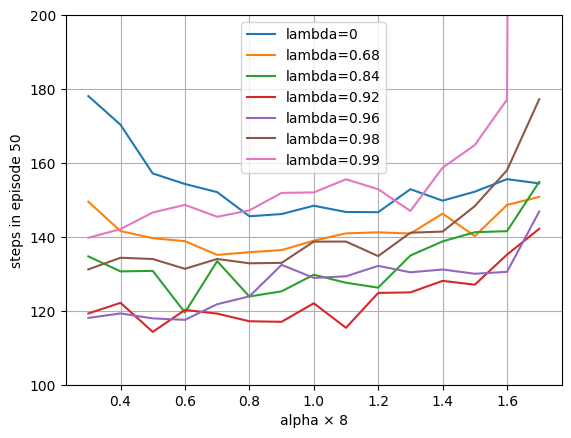

In [14]:
for i in range(len(lambdas)):
    plt.plot(alphas, np.mean(np_table[:, :, i], axis=0), label='lambda={}'.format(lambdas[i]))

plt.legend()
plt.xlabel('alpha × 8')
plt.ylabel('steps in episode 50')
plt.grid()
plt.ylim(100, 200)
plt.show()

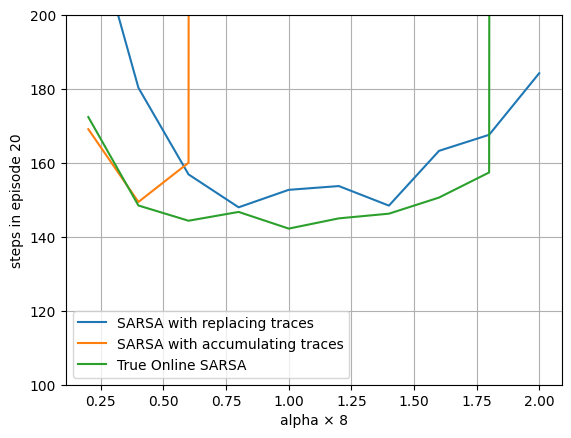

In [15]:
label = ['SARSA with replacing traces', 'SARSA with accumulating traces', 'True Online SARSA']

for i in range(3):
    plt.plot(alphas2, np.mean(np_table2[:, :, i], axis=0), label=label[i])
plt.legend()
plt.xlabel('alpha × 8')
plt.ylabel('steps in episode 20')
plt.grid()
plt.ylim(100, 200)
plt.show()